#  Muon Differential Cross-Sections
#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)
#### Danila Riazanov - Student at MIPT,  JetBrains Research trainee

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Differentiable Programming Algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

## Installation & Computation

The `conda` environment provided with the repository has all the required dependencies. For this particular tutorial we will need the following `python` packages:

In [1]:
import torch
from torch.utils.cpp_extension import load
import matplotlib.pyplot as plt

If you like dark plots:

In [2]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

Now we need to build and load `C++17/CUDA` extensions for `PyTorch`, set up the locations:

In [4]:
!mkdir -p build
noa_location = '../..'

If you are running this on Google Colab, you need to clone `NOA` and set `noa_location` accordingly:
```python
!git clone https://github.com/grinisrit/noa.git
noa_location = 'noa'
```

Also, make sure that `ninja` and `g++-9` or higher are available. The following commands will do that for you:
```python
!pip install Ninja
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt update
!apt upgrade -y
!apt install gcc-9 g++-9
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 100 --slave /usr/bin/g++ g++ /usr/bin/g++-9
```

If you are on Datalore:
```python
!pip install Ninja
!sudo apt-get update && sudo apt-get install cuda-nvcc-11-2 -y
```

Finally, you get the extensions into `python` by calling `load`:

In [5]:
muons = load(name='muons',
             build_directory='./build',
             sources=[f'{noa_location}/docs/pms/muon_dcs.cc'],
             extra_include_paths=[f'{noa_location}/src'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

In [6]:
muons_cuda = load(name='muons_cuda',
             build_directory='./build',       
             sources=[f'{noa_location}/docs/pms/muon_dcs.cu'],
             extra_include_paths=[f'{noa_location}/src'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_cuda_cflags=['-std=c++17 --extended-lambda'],
             verbose=False) if torch.cuda.is_available() else None

Differential cross-sections (DCS) are implemented in `<noa/pms/dcs.hh>` for `CPU` and `<noa/pms/physics.hh>` for `CPU/CUDA` within the namespace `noa::pms::dcs`.

Here, we demonstrate the calculations for muons passing through the standard rock. In `<noa/pms/physics.hh>` you will find:
```cpp
constexpr ParticleMass MUON_MASS = 0.10565839;     // GeV/c^2

constexpr AtomicElement<Scalar> STANDARD_ROCK =
            AtomicElement<Scalar>{
                    22.,       // Atomic mass in g/mol
                    0.1364E-6, // Mean Excitation in GeV
                    11 // Atomic number
    };
```

Let's get a range of kinetic and recoil energies:

In [7]:
kinetic_energies = torch.linspace(1e-3, 1e6, 10000).double()
recoil_energies = 0.0505 * kinetic_energies

In [8]:
kinetic_energies_gpu = kinetic_energies.cuda()
recoil_energies_gpu = recoil_energies.cuda()

## Radiative losses

Given an atom with $Z$ the charge number and $A$ the mass number (g/mol), we compute the number of atoms per unit volume:
$$
\mathcal{N} = N_A \frac{\rho}{A}
$$
for some mass density  $\rho$ (g/$\text{m}^{2}$).
Here $N_A = 6.022 \times 10^{23}$ is the Avogadro number. 

At the energy level:
$$
E = m_{mu} + K
$$
with $m_{mu} = 0.10565839$ GeV the muon rest mass and $K$ its kinetic energy,
the mean free path (m) is computed as:
$$
\langle s \rangle(E) = \frac{1}{\mathcal{N}\sigma(E)}
$$

The cross-section ($\text{m}^{2}$) is defined by:
$$
\sigma(E) = \int_{\nu_{\text{cut}}}^{\nu_{\text{max}}} \frac{\text{d}\sigma}{\text{d}\nu}(E,\nu) {\text{d}\nu} 
$$

where $\nu = \Delta E /E$ is the fraction of the muon's energy lost in the process. It's determined by a cut-off $\nu_{\text{cut}}$ below which a continuous energy loss (CEL) model is used.

Setting $x = \int \rho \text{d}s$ to be the column density along a trajectory, the mean energy loss is given by:
$$
\langle \frac{\text{d}E}{\text{d}x} \rangle(E) = E\mathcal{N} \int_{0}^{\nu_{\text{cut}}} \frac{\text{d}\sigma}{\text{d}\nu}\nu{\text{d}\nu} 
$$
where a different cross-section $\sigma$ is used for each bremsstrahlung, $e^{+}e^{-}$-pair production and photo-nuclear interactions.

For ionisation, tabulated values $a(E)$ are combined with knock-on electron production cross-section:
$$
\langle \frac{\text{d}E}{\text{d}x} \rangle_{\text{ion}} (E) = a(E) - E\mathcal{N} \int_{\nu_{\text{cut}}}^{\nu_{\text{max}}} \frac{\text{d}\sigma_{\text{ion}}}{\text{d}\nu}\nu{\text{d}\nu} 
$$

In what follows, we let:
* $m_e$ electron rest mass $0.51099891003 \cdot 10^{-3}$ GeV
* $\alpha$ fine structure constant $1/137.03599976$
* the exponential $e = 2.7181...$

Note that in our implementation we return always the value of the DCS in $\text{GeV} \cdot  \text{m}^{2} \cdot \text{kg}^{-1}$ as: 
$$ 
\frac{N_AE}{A\cdot 10^{-3}} \frac{\text{d}\sigma}{\text{d}\nu}
$$
by convention.

### Bremsstrahlung

Bremsstrahlung process corresponds to radiation due to deceleration when two charged particles interact. We will consider here the example of muons. At high energies ($E \geq 1$
TeV) this process contributes to about 40% of the average muon energy loss.
   
\begin{equation}
\frac{\text{d}\sigma}{\text{d}\nu} = \alpha Z(2\frac{m_e}{m_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) )
\end{equation}

We have the contribution from (screened) nucleus:

\begin{equation}
\Phi_n(\delta) = \ln \left( \frac{BZ^{\frac{-1}{3}}(m_\mu + \delta(D_n\sqrt{e} - 2))}{(m_e + \delta \sqrt{e}BZ^{\frac{-1}{3}})D_n} \right),
\end{equation}

where $D_n = 1.54A^{0.27}$ , $B = 182.7$ ($B = 202.4$ for hygrogen), and the contributions from atomic electrons:
\begin{equation}
\Phi_\text{in}(\delta) = \ln \left( \frac{m_\mu BZ^{-2/3} \sqrt{e}}{(m_e + \delta  BZ^{-2/3} \sqrt{e})(\frac{m_\mu \delta}{m_e^{2}} + \sqrt{e})} \right),
\end{equation}

where $B = 1429$ ($B = 446$ for hygrogen). 

Both are evaluated at: 

\begin{equation}
\delta = \frac{m_\mu^{2}\nu}{2E(1 - \nu)}
\end{equation}

See:
* D. Groom et. al. [Muon stopping power and range tables 10 MeV - 100 TeV](https://pdg.lbl.gov/2014/AtomicNuclearProperties/adndt.pdf)

For `CPU` we have:
```cpp
dcs::map(
  dcs::bremsstrahlung)(
    kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```
For `CUDA` we create the lambda function directly ourselves:
```cpp
dcs::cuda::map_bremsstrahlung(
  kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [9]:
brems = muons.bremsstrahlung(kinetic_energies, recoil_energies)
brems[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       dtype=torch.float64)

In [10]:
brems_gpu = muons_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);
brems_gpu[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       device='cuda:0', dtype=torch.float64)

In [11]:
(brems - brems_gpu.cpu()).abs().sum()

tensor(3.2941e-18, dtype=torch.float64)

In [12]:
%timeit muons_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);

155 µs ± 3.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
%timeit muons.bremsstrahlung(kinetic_energies, recoil_energies);

295 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Pair Production

Direct electron-positron pair production is taken from [Geant4](https://geant4-userdoc.web.cern.ch/UsersGuides/PhysicsReferenceManual/fo/PhysicsReferenceManual.pdf) see p.151 using [gaussian quadrature](https://pomax.github.io/bezierinfo/legendre-gauss.html).

We have:

\begin{equation}
\frac{\text{d}\sigma}{\text{d}\nu} = \frac{4}{3\pi} \frac{Z(Z + \xi(Z))}{A} N_A {(\alpha r_e)}^{2} \frac{1 - \nu}{\nu} \int_{0}^{p_{\text{max}}}(\Phi_e + (m_e/m_\mu)^{2}\Phi_\mu)dp,
\end{equation}

where $\Phi_{e,\mu} = B_{e,\mu} {L^{\text{'}}_{e,\mu}}$  and  $\Phi_{e,\mu} = 0$  whenever $\Phi_{e,\mu}<0$, and the upper bound for the integral is:

\begin{equation}
p_{\text{max}} = 1 - \frac{6 m_\mu^2}{E^2(1 - \nu)})\sqrt{1 - \frac{4m_e}{E\nu}} 
\end{equation}

$B_e$ and $B_\mu$ do not depend on $Z, A$, and are given by

\begin{equation}
B_e = (2 + p^{2})(1 + \beta) + \xi(3 + p^{2})\ln(1 + \frac{1}{\xi}) + \frac{1 - p^{2} - \beta}{1 + \xi} - (3 + p^{2})
\end{equation}

with:

\begin{equation}
B_e \approx \frac{1}{2\xi}((3 - p^{2}) + 2\beta(z + p^{2})) \text{ for } \xi \geq 10 ^{3}
\end{equation}

and

\begin{equation}
B_\mu = ((1 + p^{2})(1 + \frac{3\beta}{2}) - \frac{1}{\xi}(1 + 2\beta)(1 - p^{2}))\ln(1 + \xi) + \frac{\xi(1 - p^{2} - \beta)}{1 + \xi} + (1 + 2\beta)(1 - p^{2})
\end{equation}

with 

\begin{equation}
B_e \approx \frac{\xi}{2}(5 - p^{2}) + \beta(3 + p^{2}) \text{ for } \xi \leq 10^{-3}
\end{equation}

Also,


\begin{equation}
\xi = \frac{m_\mu^{2}\nu^{2}}{4m_e^{2}} \frac{(1 - p^{2})}{1 - \nu}; \quad
\beta = \frac{\nu^{2}}{2(1 - \nu)}
\end{equation}

\begin{equation}
L_e^\text{'} = \ln \left( \frac{ A^{ * } Z^{-1/3} \sqrt{(1 + \xi)(1 + Y_e)}}{1 + \frac{2m_e\sqrt{e} A^{ * } Z^{-1/3}(1 + \xi)(1 + Y_\mu)}{E\nu(1 - p^{2})}} \right)  - \frac{1}{2} \ln \left(1 + (\frac{3m_eZ^{1/3}}{2m_\mu})^{2}(1 + \xi)(1 + Y_e) \right)
\end{equation}

\begin{equation}
L_\mu ^\text{'} = \ln \left(\frac{(\frac{m_\mu}{m_e})A^{ * } Z^{-1/3} \sqrt{(1 + \frac{1}{\xi})(1 + Y_e)}}{1 + \frac{2m_e\sqrt{e}A^{ * } Z^{-1/3}(1 + \xi)(1 + Y_\mu)}{E\nu(1 - p^{2})}} \right)  - \ln \left( \frac{3}{2} Z^{1/3}\sqrt{(1 + \frac{1}{\xi})(1 + Y_\mu)} \right)
\end{equation}

where $A^{ * }= 183$ is a constant. For faster computation, the expressions for $L_{e, \mu} ^\text{'}$ are further transformed and include the nuclear size correction:

\begin{equation}
Y_e = \frac{5 - p^2 + 4\beta(1 + p^2)}{2(1 + 3\beta)\ln(3 + 1/\xi)) - p^2 - 2\beta(2 - p^2)}
\end{equation}

\begin{equation}
Y_\mu = \frac{4 + p^2 + 3\beta(1 + p^2)}{(1 + p^2)(\frac{3}{2} + 2\beta)\ln(3 + \xi) + 1 - \frac{3}{2} p^2}
\end{equation}

Only a `CPU` version is available as of now:
```cpp
dcs::vmap(
  dcs::pair_production)(
    kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [14]:
ppair = muons.pair_production(kinetic_energies, recoil_energies)
ppair[:5]

tensor([0.0000e+00, 6.5366e-06, 7.3699e-06, 7.7919e-06, 8.0572e-06],
       dtype=torch.float64)

### Photonuclear

The theory is taken from [Dutta et. al.](https://arxiv.org/pdf/hep-ph/0012350.pdf).
 
The differential cross section can be written in the form:

$$
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} = \frac{4\pi\alpha^2}{Q^4}\frac{F_2(x, Q^2)}{x}(1-y-\frac{Mxy}{2E} + (1 - \frac{2 m_\mu^2}{Q^2})\frac{y^2(1 + \frac{4M^2x^2}{Q^2})}{2(1 + R(x, Q^2))})
$$

where the following relations are used:
$$
q = \Delta E, \quad y = \nu, \quad \text{and} \quad  x = \frac{Q^2}{2Mq}
$$
for $M=0.931494$ the nucleon mass (GeV).

The expression $F_2$ is the nucleon structure function:

$$
F_2(x, Q^2) = \frac{Q^2}{Q^2 + m_0^2} (F_2^P(x, Q^2) + F_2^R(x, Q^2))
$$
where $m_0$ is the effective photon mass. Further:
$$
F_2 ^{R}(x, Q^{2}) = c_R(t)x_R^{a_R(t)}(1 - x)^{b_R(t)} 
= c_R(t)e^{a_R(t)\ln x_R+ b_R(t)\ln(1 - x)}
$$

$$
F_2 ^{P}(x, Q^{2}) = c_P(t)x_P^{a_P(t)}(1 - x)^{b_P(t)} 
= c_P(t)e^{\ln(x_P^{a_P(t)}(1 - x)^{b_P(t)})}
= c_P(t)e^{\ln x_P^{a_P(t)}+ \ln(1 - x)^{b_P(t)}}
= c_P(t)e^{a_P(t)\ln x_P+ b_P(t)\ln(1 - x)}
$$

Using the parametrizations from [Abramowicz et. al.](https://arxiv.org/pdf/hep-ph/9712415.pdf), we obtain:

$$
\begin{split}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} & = \frac{4\pi\alpha^2 F_2}{Q^4} \frac{2Mq}{Q^2}(1 - y - \frac{My}{2E}\frac{Q^2}{2Mq} + (1 - \frac{2m_\mu^2}{Q^2})\frac{y^2(1 + (\frac{2MQ^2}{2MqQ})^2)}{2(1 + R)}) \\
& = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y - \frac{Q^2y}{4Eq} + (1 - \frac{2m_e^2}{Q^2}) \frac{y^2 + (y\frac{Q}{q})^2}{2(1 + R)})
\end{split}
$$

rewriting using $y = \frac{q}{E}$:

$$
\begin{split}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}x} & = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y - \frac{Q^2}{4E^2} + (1 - \frac{2m_e^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)}) \\
& = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y  + (1 - \frac{2m_e^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)}) - \frac{8\pi\alpha^2F_2Mq}{Q^6}\frac{Q^2}{4E^2} \\
& = \frac{8\pi\alpha^2F_2Mq}{Q^6}(1 - y  + (1 - \frac{2m_e^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{2(1 + R)}) - \frac{8\pi\alpha^2F_2Mq}{4Q^4E^2} \\
& = \frac{8\pi\alpha^2F_2Mq}{Q^2}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_e^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
\end{split}
$$

Moving to $x = \frac{Q^2}{2Mq}$

$$
\frac{\text{d}x}{\text{d}q} = \frac{-Q^2}{2Mq^2}
$$

which gives:
$$
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q}\frac{2Mq^2}{-Q^2} = \frac{8\pi\alpha^2F_2Mq}{Q^2}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_e^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
$$

so that in the end we get:

$$
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q} = \frac{-4\pi\alpha^2F_2}{q}((\frac{1 - y  + \frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac{y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4}) - \frac{1}{4Q^2E^2})
$$

We should add some approximation factors:

\begin{equation}
\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q} = \frac{c_f F_2}{q} (\frac{1-y+\frac{1}{2}(1 - \frac{2m_l^2}{Q^2}) \frac {y^2 + \frac{Q^2}{E^2}}{1 + R}}{Q^4} - \frac{1}{4E^2Q^2})
\end{equation}

with a constant factor $c_f = 2.603096 \cdot 10^{-35}$. To get the final result, we integrate this equation using gaussian quadrature over $Q^2$ from $Q_\text{min}^2 = \frac{m_e^2y^2}{1 - y} $ to $Q_\text{max}^2 = 2MEy - ((M + m_\pi)^2 - M^2)$ where $m_\pi=0.134977$ GeV is the mass of a pion:

$$
\frac{\text{d}\sigma}{\text{d}\nu} = E \int{\frac{\text{d}\sigma(x, Q^2)}{\text{d}Q^2\text{d}q}}\text{d}Q^2
$$

Only a `CPU` version is available:
```cpp
dcs::vmap(
  dcs::photonuclear)(
    kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [15]:
photonuc = muons.photonuclear(kinetic_energies, recoil_energies)
photonuc[:5]

tensor([0.0000e+00, 2.2912e-06, 2.1304e-06, 2.0719e-06, 2.0427e-06],
       dtype=torch.float64)

### Ionisation

We deal only with the knock-on electron production $\sigma_{\text{ion}}$ from above, basing ourselves on Salvat et al., NIMB316 (2013) 144-159, and [Sokalski et al.](https://arxiv.org/pdf/hep-ph/0106011.pdf).

The differential cross section reads:

$$
\frac{\text{d}\sigma}{\text{d}\nu} = \frac{1.535336 \cdot 10^{-2}Z}{N_A(\frac{1}{2P_2} + \frac{P_2W_\text{max}}{E^2W_\text{max} - qP_2})}(1 + \Delta_{e\gamma}),
$$

where $P_2 = E^2 - m_\mu^2$ and $W_{max} = \frac{2m_e P_2}{m_\mu^2 + m_e(m_e + 2E)}$.

The radiative correction is given by:

$$
\Delta_{e\gamma} = \frac{\alpha}{2\pi}\ln\left(1 + \frac{2\nu E}{m_e}\right)\left(\ln(\frac{4E^2(1 - \nu)}{M_\mu^2}) - \ln(1 + \frac{2\nu E}{m_e})\right)
$$

Only `CPU` implementation is available:

```cpp
dcs::vmap(
  dcs::ionisation)(
     kinetic_energies, recoil_energies, STANDARD_ROCK, MUON_MASS);
```

In [16]:
ionis = muons.ionisation(kinetic_energies, recoil_energies)
ionis[:5]

tensor([0.0000e+00, 3.0168e-05, 1.5300e-05, 1.0284e-05, 7.7575e-06],
       dtype=torch.float64)

## Mean free path in rock

In [123]:
rock_density = 2.65e+3

In [240]:
nlevels = 50
nsample = 50
henergy = 1000
lenergy = 700
kenergies = torch.linspace(lenergy, henergy, nlevels).repeat(nsample) \
    .reshape(nsample,nlevels).double()
recoil_levels = torch.linspace(0.05, 0.1, nsample)
renergies = kenergies * recoil_levels.reshape((nsample,1))

In [241]:
brems = rock_density * \
    muons.bremsstrahlung(kenergies, renergies).reshape(nsample,nlevels) / \
    kenergies
pairs = rock_density * \
    muons.pair_production(kenergies, renergies).reshape(nsample,nlevels) / \
    kenergies
photo = rock_density * \
    muons.photonuclear(kenergies, renergies).reshape(nsample,nlevels) / \
    kenergies
ion = rock_density * \
    muons.ionisation(kenergies, renergies).reshape(nsample,nlevels) / \
    kenergies

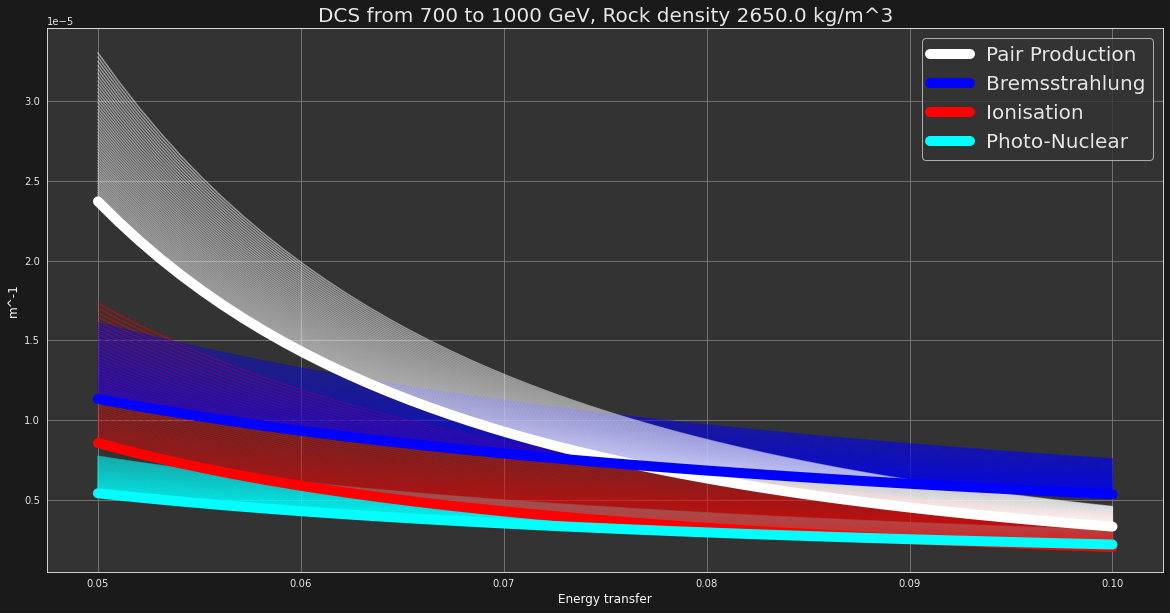

In [243]:
fig, ax = plt.subplots() 

ax.plot(recoil_levels.numpy(), photo.numpy(), 'cyan', alpha=0.5)
ax.plot(recoil_levels.numpy(), ion.numpy(), 'red', alpha=0.5)
ax.plot(recoil_levels.numpy(), brems.numpy(),'blue',alpha=0.5)
ax.plot(recoil_levels.numpy(), pairs.numpy(), 'white', alpha=0.5)


ax.plot(recoil_levels.numpy(), pairs.T[-1].numpy(),'white', linewidth=10, 
        label = f'Pair Production')
ax.plot(recoil_levels.numpy(), brems.T[-1].numpy(),'blue', linewidth=10, 
        label = f'Bremsstrahlung')
ax.plot(recoil_levels.numpy(), ion.T[-1].numpy(),'red', linewidth=10, label = 'Ionisation') 
ax.plot(recoil_levels.numpy(), photo.T[-1].numpy(),'cyan', linewidth=10, 
        label = f'Photo-Nuclear')


ax.set_xlabel('Energy transfer', fontsize = 12, color='white')
ax.set_ylabel('m^-1', fontsize = 12, color='white')
ax.set_title(f"DCS from {lenergy} to {henergy} GeV, Rock density {rock_density} kg/m^3",
             fontsize = 20)
    
fig.set_figwidth(20)
fig.set_figheight(10)
ax.legend(fontsize=20)
plt.show()